# MY NOTEBOOK

## CONFIG

In [1]:
%load_ext autoreload
%autoreload

### Imports

In [2]:
import os
import fnmatch
import re
import random
import time
import sys

import librosa
import tensorflow as tf

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 

import itertools

#import progressbar
from tqdm import tqdm_notebook as tqdm
from time import sleep

from models import *

## Constants

### Local Machine

In [107]:
MTT_DIR = "../MTT/"
DATA_DIRECTORY = MTT_DIR + "dataset/"
# CSV containing song details (title, artist, id, mp3_path,...)
CLIP_INFO_FINAL = "clip_info_final.csv"
# CSV containg the labels (clip_id, labels, mp3_path)
ANNOTATIONS_FINAL = "annotations_final.csv"
# CSV : what is it useful for ?
COMPARISONS_FINAL = "comparisons_final.csv"
LABELS_FILE = MTT_DIR + ANNOTATIONS_FINAL

SUB_DIRS = "0123456789abcdef"

LOGDIR = "checkpoints/"

AUDIO1_path = "../MTT/mtt_data_mp3.zip/0/american_bach_soloists-j_s__bach_\
_transcriptions_of_italian_music-02-concerto_in_a_minor_for_four_harpsichords\
_bwv_1065_ii_largo-88-117.mp3"

### LTS2 Server

This cell defines all the needed data paths, when running on LTS2 server.
Don't run this cell if you are not running the jupyter notebook on the LTS2 server ! (will overwrite the variables defined on the cell above).

You can either create a cell with your own paths, or modify the cell above with your custom paths.

In [ ]:
MTT_DIR = "/mnt/scratch/students/jjgweber-MagnaTagATune/"
DATA_DIRECTORY = MTT_DIR + "dataset/"

# CSV containg the labels (clip_id, labels, mp3_path)
ANNOTATIONS_FINAL = "annotations_final.csv"

LABELS_FILE = MTT_DIR + ANNOTATIONS_FINAL

# need to create this directory on the server !!
LOGDIR = "checkpoints/"

SUB_DIRS = "0123456789abcdef"

### Data

In [4]:
FILE_NB = 25880 #25863
FILE_LENGTH = 465984
# 465984 = 2 × 2 × 2 × 2 × 2 × 2 × 3 × 3 × 809
# useful for batches > for now divide by 9 (instead of 10)

BATCH_NB = 9
BATCH_SIZE = int(FILE_LENGTH/BATCH_NB)
SAMPLE_SIZE = 0
SAMPLE_RATE = 16000
RECEPTIVE_FIELD = 0

TRAIN_DIR = "0123456789abcde"
TEST_DIR ="f"

BASIC_CONFIG ={'numOutputNeurons':500}
LEARNING_RATE = 0.001

### Mutable parameters

In [5]:
# Variables which are often modified to test the algorithm
NB_SONGS = 6
EPOCHS = 20 # check in paper
LABELS_NAME = ['guitar']
NB_LABELS = len(LABELS_NAME)

## Loading tool functions

In [12]:
def load_labels(labels_file_name):
    pd.read_csv(labels_file_name)

def randomize_files(files):
    for file in files:
        file_index = random.randint(0, (len(files) - 1))
        yield files[file_index]


# ATTENTION : in the current configuration, everytime this function is called it goes through 
# all the sub-directories even if the sample is set to 6
# it only prunes the output at the end
# > there could be a more efficient way for doing this
# TODO later
def find_files(directory, pattern='*.mp3', sample=None, sub_dir=None):
    '''Recursively finds all files matching the pattern.'''
    # subdir sould be a string, for example "abc03", 
    # meaning we take data from directories a,b,c,0 and 3
    
    files = []
    directories = []
    
    # TODO : add lines to check format of input
    # TODO : try/except ?
    
    if sub_dir!=None :
        for c in sub_dir :
            directories.append(directory+c+"/")
    else :
        directories.append(directory)
    
    for path in directories :
        for root, dirnames, filenames in os.walk(path):
            for filename in fnmatch.filter(filenames, pattern):
                files.append(os.path.join(root, filename))

    if sample!=None :
        try:
            return files[:sample]
        except TypeError:
            print("Argument sample should be either None, or an integer :\
             the number of first n samples to take.")
    else :
        return files

## Prediction labels

### Load and clean

In [7]:
labels = pd.read_csv(LABELS_FILE, sep = '"\t"')

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [8]:
# Prepare header to put back in the end
# remove quotes and take all columns except the first one
header = list(map(lambda x : x.replace('"', ''), labels))[1:]
# add back the first column, separated in two
header = ['clip_id', 'no_voice']+header
# create dictionary
header = dict(enumerate(header))

In [9]:
# Solve format problem : two first columns are merged
# extract first column and rest
left, right = labels['"clip_id\t""no voice"'], labels.iloc[:, 1:]
# split first column in two part at separator "\t"
split = left.str.split(pat = "\t", expand=True).replace('"', '')

# put back the first column which is now two, with the rest
cleaned = pd.concat([split, right], axis=1, ignore_index=True) 
# clean by removing quotes and add back header
cleaned = cleaned.apply(lambda col : col.apply(lambda x : x.replace('"', ''))).rename(columns = header)
cleaned.head(5)

,clip_id,no_voice,singer,duet,plucking,hard rock,world,bongos,harpsichord,female singing,...,rap,metal,hip hop,quick,water,baroque,women,fiddle,english,mp3_path
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,f/american_bach_soloists-j_s__bach_solo_cantat...
1,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,f/american_bach_soloists-j_s__bach_solo_cantat...
2,10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,f/american_bach_soloists-j_s__bach_solo_cantat...
3,11,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,f/american_bach_soloists-j_s__bach_solo_cantat...
4,12,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,f/american_bach_soloists-j_s__bach_solo_cantat...


### Analyse the dataset

In [ ]:
## TODO : Some statistics on the MTT dataset ?
nb_labels_per_song = cleaned.iloc[:,1:-1].astype(int).sum(axis=1)
nb_song_per_label = cleaned.iloc[:,1:-1].astype(int).sum(axis=0)
nb_song_per_label = nb_song_per_label.sort_values(ascending=False)

In [ ]:
# label header is the header without clip_id and mp3_path > length 188 instead of 190
label_header = np.asarray(list(header.values()))[1:-1]
label_header_by_freq = np.asarray(nb_song_per_label.index)

In [ ]:
fig = plt.figure(figsize=(16,6))

plot_nb = 70

y_pos = np.arange(plot_nb)
plt.bar(y_pos, nb_song_per_label[:plot_nb], align='center', alpha=0.5)
plt.xticks(y_pos, nb_song_per_label[:plot_nb])
plt.ylabel('Occurence')
plt.title('Label histogram')
plt.xticks(np.arange(plot_nb), label_header_by_freq[:plot_nb], rotation=90, fontsize = 13)

plt.show()

In [ ]:
# Find the most frequent labels to start with for training
most_freq = nb_song_per_label
for i in range(len(nb_song_per_label)) :
    if nb_song_per_label[i] > 2000:
        print(i, "> ", label_header_by_freq[i], " -- ", nb_song_per_label[i])

In [ ]:
best_10_labels = label_header_by_freq[:10]
best_30_labels = label_header_by_freq[:30]

In [ ]:
print("Number of songs : " , cleaned.shape[0])
print("Number of labels : " , cleaned.shape[1]-2) # -2 is for index columns and mp3 path column
print("Max number of songs tagged with the same label : ",max(nb_song_per_label))
print("Max number of labels for a single song : ",max(nb_labels_per_song))

## Co-occurence matrix

Code from : https://stackoverflow.com/questions/20574257/constructing-a-co-occurrence-matrix-in-python-pandas

In [ ]:
def show_values(pc, fmt="%.2f", **kw):
    '''
    Heatmap with text in each cell with matplotlib's pyplot
    Source: http://stackoverflow.com/a/25074150/395857 
    By HYRY
    '''
    #from itertools import izip
    pc.update_scalarmappable()
    ax = pc.axes
    for p, color, value in zip(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.all(color[:3] > 0.5):
            color = (0.0, 0.0, 0.0)
        else:
            color = (1.0, 1.0, 1.0)
        ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw)

def cm2inch(*tupl):
    '''
    Specify figure size in centimeter in matplotlib
    Source: http://stackoverflow.com/a/22787457/395857
    By gns-ank
    '''
    inch = 2.54
    if type(tupl[0]) == tuple:
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)

def heatmap(AUC, title, xlabel, ylabel, xticklabels, yticklabels):
    '''
    Inspired by:
    - http://stackoverflow.com/a/16124677/395857 
    - http://stackoverflow.com/a/25074150/395857
    '''

    # Plot it out
    fig, ax = plt.subplots()    
    c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap='RdBu', vmin=0.0, vmax=1.0)

    # put the major ticks at the middle of each cell
    ax.set_yticks(np.arange(AUC.shape[0]) + 0.5, minor=False)
    ax.set_xticks(np.arange(AUC.shape[1]) + 0.5, minor=False)

    # set tick labels
    #ax.set_xticklabels(np.arange(1,AUC.shape[1]+1), minor=False)
    ax.set_xticklabels(xticklabels, minor=False)
    ax.set_yticklabels(yticklabels, minor=False)

    # set title and x/y labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)      

    # Remove last blank column
    plt.xlim( (0, AUC.shape[1]) )

    # Turn off all the ticks
    ax = plt.gca()    
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    # Add color bar
    plt.colorbar(c)

    # Add text in each cell 
    show_values(c)

    # Proper orientation (origin at the top left instead of bottom left)
    ax.invert_yaxis()
    ax.xaxis.tick_top()

    # resize 
    fig = plt.gcf()
    fig.set_size_inches(cm2inch(40, 20))



def check_overlaps(label_headers, label_data):


    print('labels:\n{0}'.format(label_data))

    # Compute cooccurrence matrix 
    cooccurrence_matrix = np.dot(label_data.transpose(),label_data)
    print('\ncooccurrence_matrix:\n{0}'.format(cooccurrence_matrix)) 

    # Compute cooccurrence matrix in percentage
    # FYI: http://stackoverflow.com/questions/19602187/numpy-divide-each-row-by-a-vector-element
    #      http://stackoverflow.com/questions/26248654/numpy-return-0-with-divide-by-zero/32106804#32106804
    cooccurrence_matrix_diagonal = np.diagonal(cooccurrence_matrix)
    with np.errstate(divide='ignore', invalid='ignore'):
        cooccurrence_matrix_percentage = np.nan_to_num(np.true_divide(cooccurrence_matrix, \
                                                                      cooccurrence_matrix_diagonal[:, None]))
    print('\ncooccurrence_matrix_percentage:\n{0}'.format(cooccurrence_matrix_percentage))

    # Add count in labels
    label_header_with_count = [ '{0} ({1})'.format(label_header, cooccurrence_matrix_diagonal[label_number]) \
                               for label_number, label_header in enumerate(label_headers)]  
    print('\nlabel_header_with_count: {0}'.format(label_header_with_count))

    # Plotting
    x_axis_size = cooccurrence_matrix_percentage.shape[0]
    y_axis_size = cooccurrence_matrix_percentage.shape[1]
    title = "Co-occurrence matrix\n"
    xlabel= ''#"Labels"
    ylabel= ''#"Labels"
    xticklabels = label_header_with_count
    yticklabels = label_header_with_count
    heatmap(cooccurrence_matrix_percentage, title, xlabel, ylabel, xticklabels, yticklabels)
    plt.savefig('image_output.png', dpi=300, format='png', bbox_inches='tight') 
    # use format='svg' or 'pdf' for vectorial pictures
    #plt.show()

In [ ]:
chosen_labels = best_10_labels
check_overlaps(chosen_labels, cleaned.loc[:,chosen_labels].values.astype(int))

## Load and format mp3 data 

In [79]:
# TODO : not efficient to 
# - give the whole label dataset to the function as argument
# - look in the label dataset at each iteration to retrieve the label
#   > should concat before randomize
# - append to an array and then convert to numpy ? > check

# labels_name : liste of columns name which we want to load

def load_audio_label(labels, num_songs=NB_SONGS, sample_rate=None, directory=DATA_DIRECTORY, labels_name=LABELS_NAME, sub_dir=None):
    files = find_files(directory, sample=num_songs, sub_dir=sub_dir)
    randomized_files = randomize_files(files)
    count = 0
    audios = np.ndarray(shape=(num_songs, BATCH_NB, BATCH_SIZE, 1), dtype=np.float32, order='F')
    tags = np.ndarray(shape=(num_songs, BATCH_NB, NB_LABELS), dtype=np.float32, order='F')
    
    for filename in randomized_files:

        # Load MP3 file        
        try :
            audio, _ = librosa.load(filename, sr=sample_rate, mono=True)
        except EOFError :
            print("EOFERROR : The following file could not be loaded with librosa - ", filename)

        audio = audio.reshape(-1, 1)

        #create batches
        audio_batch = np.ndarray(shape=(BATCH_NB, BATCH_SIZE, 1), dtype=np.float32, order='F')
        label_batch = np.ndarray(shape=(BATCH_NB, NB_LABELS), dtype=np.float32, order='F')
        for n in range(BATCH_NB) :
            audio_batch[n] = audio[n*BATCH_SIZE: (n+1)*BATCH_SIZE,:]
            
            # take labels or corresponding mp3 song
            select_labels  = labels.loc[labels['mp3_path']==filename[len(DATA_DIRECTORY):]]

            # select wanted labels
            select_labels = select_labels[labels_name]

            label_batch[n] = select_labels.values.reshape(NB_LABELS)
        
        audios[count] = audio_batch
        tags[count] = label_batch
        
        count +=1
        if (count % 10) == 0:
            print(count)

    return audios, tags

In [80]:
# load audios and labels > convert to numpy
# CAREFUL : the argument num_songs is important and shouldn't be too big 
# > otherwise MEMORY ISSUES !!!!!!
print("Loading data ...")
start = time.time()
audios, tags = load_audio_label(cleaned, sub_dir=TRAIN_DIR)
end = time.time()
duration = end-start
print(">> Total loading time - {} songs : {:.2f} sec".format(NB_SONGS, duration))

Loading data ...
>> Total loading time - 6 songs : 0.33 sec


In [81]:
print("Shape of audios list :")
print(audios.shape)
print()
print(">> shape is : [num_song, num_batches, batch_size, 1]")


Shape of audios list :
(6, 9, 51776, 1)

>> shape is : [num_song, num_batches, batch_size, 1]


In [82]:
print("Shape of tags list :")
print(tags.shape)
print()
print(">> shape is : [num_song, num_labels (mp3 file and id excluded), 1] ")
print("(or : [num_song, num_labels, 1, str_len, 1])")

Shape of tags list :
(6, 9, 1)

>> shape is : [num_song, num_labels (mp3 file and id excluded), 1] 
(or : [num_song, num_labels, 1, str_len, 1])


In [72]:
# put all batches at the same level (remove song dimension in the array)
# ex : go from dimensions (n, m, k, 1) > to (n*m, k, 1)
audios_flatten = audios.reshape(-1, audios.shape[-2], audios.shape[-1])
tags_flatten = tags.reshape(-1, tags.shape[-1])

## Neural Network model

In [142]:
def save(saver, sess, logdir, step):
    model_name = 'model.ckpt'
    checkpoint_path = os.path.join(logdir, model_name)
    print('Storing checkpoint to {} ...'.format(logdir), end="")
    sys.stdout.flush()

    if not os.path.exists(logdir):
        os.makedirs(logdir)

    saver.save(sess, checkpoint_path, global_step=step)
    print(' Done.')

In [153]:
# run this cell everytime before relaunching tensorflow session
tf.reset_default_graph()

### Training

In [154]:
# keep results for plotting
train_loss_results = []
train_auc_results = []

In [155]:
print("Initializing tf model ...")
EPOCHS = 6

audio_tf= tf.convert_to_tensor(audios_flatten, np.float32)
print("Input shape : {}".format(audio_tf.shape))
print("Labels : {}".format(tags_flatten.flatten()))
print()

net = build_model(audio_tf, is_training=True, config=BASIC_CONFIG) 
predictions = tf.layers.dense(net, NB_LABELS, activation=tf.sigmoid)
loss = tf.nn.sigmoid_cross_entropy_with_logits(labels = tags_flatten, logits = predictions)
reduced_loss = tf.reduce_mean(loss)
train_op = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(reduced_loss)
auc = tf.metrics.auc(labels = tags_flatten, predictions=predictions)


# Saver for storing checkpoints of the model. (Wavenets)
saver = tf.train.Saver(var_list=tf.trainable_variables())
    
print("Start training...")

start = time.time()

with tf.Session() as sess:
    init = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
    
    sess.run(init)
    for i in tqdm(range(EPOCHS)):
        predict, _, loss_value, auc_score = sess.run([predictions, train_op, reduced_loss, auc])
        
        auc_result, update_op = auc_score
        
        train_loss_results.append(loss_value)
        train_auc_results.append(auc_result)
        
        print("Iter: {:2}, Loss: {:.4f}, AUC : {:.4f}".format(i, loss_value, auc_result))
        #print("Predictions : {}".format(predict.flatten()))
        #print()
     
    # use wavenet function > see later (for now simplest way)
    #save(saver, sess, LOGDIR, EPOCHS)
    saver.save(sess, "./tmp/checkpoint_test")

end = time.time()
duration2 = end-start
print("Total time: {:.2f} sec.".format(duration2))

Initializing tf model ...
Input shape : (54, 51776, 1)
Labels : [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]

Start training...


Iter:  0, Loss: 0.8526, AUC : 0.0000
Iter:  1, Loss: 0.7886, AUC : 0.7037
Iter:  2, Loss: 0.7404, AUC : 0.8750
Iter:  3, Loss: 0.7087, AUC : 0.9362
Iter:  4, Loss: 0.6756, AUC : 0.9613
Iter:  5, Loss: 0.6665, AUC : 0.9752
Total time: 34.64 sec.


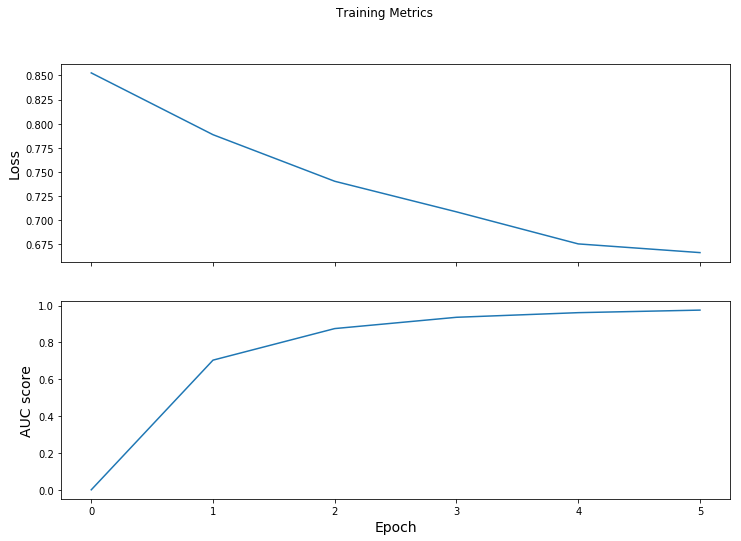

In [156]:
# modify this : the epoch axis not not integers which doesn't make sense
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("AUC score", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_auc_results)
plt.show()

## Test set

In [157]:
TEST_SIZE = 10

audios_test, tags_test = load_audio_label(cleaned, num_songs=TEST_SIZE, sub_dir=TEST_DIR)

audios_test = audios_test.reshape(-1, audios_test.shape[-2], audios_test.shape[-1])
tags_test = tags_test.reshape(-1, tags_test.shape[-1])

audios_test_tf = tf.convert_to_tensor(audios_test, np.float32)


10


In [158]:
#tf.reset_default_graph()

variables_to_restore = {
    var.name[:-2]: var for var in tf.global_variables()
    if not ('state_buffer' in var.name or 'pointer' in var.name)}

# Add ops to save and restore all the variables.
saver = tf.train.Saver(variables_to_restore)

# Later, launch the model, use the saver to restore variables from disk, and
# do some work with the model.
with tf.Session() as sess:
  # Restore variables from disk.
  saver.restore(sess, "/tmp/model.ckpt")
  print("Model restored.")
  # Check the values of the variables

ValueError: The passed save_path is not a valid checkpoint: /tmp/model.ckpt

In [145]:
tf.reset_default_graph()

sess = tf.Session() 

last_checkpoint = "./checkpoints/model.ckpt-6" # >> check what argument was passed when running wavenets


variables_to_restore_glob = {
    var.name[:-2]: var for var in tf.global_variables()
    if not ('state_buffer' in var.name or 'pointer' in var.name)}

#variables_to_restore_loc = {
 #   var.name[:-2]: var for var in tf.local_variables()
  #  if not ('state_buffer' in var.name or 'pointer' in var.name)}

variables_to_restore = dict(variables_to_restore_glob)
#variables_to_restore.update(variables_to_restore_loc)

saver = tf.train.Saver(variables_to_restore)

print('Restoring model from {}'.format(last_checkpoint))
saver.restore(sess, last_checkpoint)


    
init = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())

sess.run(init) 

predicts = sess.run([audios_test_tf, predictions, train_op, reduced_loss, auc])

Restoring model from ./checkpoints/model.ckpt-6
INFO:tensorflow:Restoring parameters from ./checkpoints/model.ckpt-6


NotFoundError: Restoring from checkpoint failed. This is most likely due to a Variable name or other graph key that is missing from the checkpoint. Please ensure that you have not altered the graph expected based on the checkpoint. Original error:

Key 1cnnOut/bias/Adam not found in checkpoint
	 [[node save_5/RestoreV2 (defined at <ipython-input-145-4b9de4754f41>:17)  = RestoreV2[dtypes=[DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, ..., DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save_5/Const_0_0, save_5/RestoreV2/tensor_names, save_5/RestoreV2/shape_and_slices)]]

Caused by op 'save_5/RestoreV2', defined at:
  File "/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/anaconda3/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "/anaconda3/lib/python3.6/asyncio/base_events.py", line 422, in run_forever
    self._run_once()
  File "/anaconda3/lib/python3.6/asyncio/base_events.py", line 1432, in _run_once
    handle._run()
  File "/anaconda3/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/anaconda3/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 117, in _handle_events
    handler_func(fileobj, events)
  File "/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-145-4b9de4754f41>", line 17, in <module>
    saver = tf.train.Saver(variables_to_restore)
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1102, in __init__
    self.build()
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1114, in build
    self._build(self._filename, build_save=True, build_restore=True)
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1151, in _build
    build_save=build_save, build_restore=build_restore)
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 795, in _build_internal
    restore_sequentially, reshape)
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 406, in _AddRestoreOps
    restore_sequentially)
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 862, in bulk_restore
    return io_ops.restore_v2(filename_tensor, names, slices, dtypes)
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gen_io_ops.py", line 1466, in restore_v2
    shape_and_slices=shape_and_slices, dtypes=dtypes, name=name)
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3274, in create_op
    op_def=op_def)
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1770, in __init__
    self._traceback = tf_stack.extract_stack()

NotFoundError (see above for traceback): Restoring from checkpoint failed. This is most likely due to a Variable name or other graph key that is missing from the checkpoint. Please ensure that you have not altered the graph expected based on the checkpoint. Original error:

Key 1cnnOut/bias/Adam not found in checkpoint
	 [[node save_5/RestoreV2 (defined at <ipython-input-145-4b9de4754f41>:17)  = RestoreV2[dtypes=[DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, ..., DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save_5/Const_0_0, save_5/RestoreV2/tensor_names, save_5/RestoreV2/shape_and_slices)]]


## Other structure (test)

Following TF tutorial for custom training
https://github.com/tensorflow/docs/blob/master/site/en/tutorials/eager/custom_training_walkthrough.ipynb